## Import

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Load and prepare data

In [2]:
# Load the data into a DataFrame
file_path = r'C:\Users\nmilo\OneDrive\Desktop\Studium\Bachelorarbeit\pfr.combine\new_data_final_cleaned.xlsx'
df = pd.read_excel(file_path)

# Define target variable (binary classification)
df['NFL_Games_Binary'] = (df['NFL Games'] > 17).astype(int)  # 17 Games is the 50th percentile

# Define features
features = df.drop(columns=['NFL Games', 'NFL_Games_Binary', 'Player', 'Pos', 'Ht', 'Drafted', 'NFL Snaps', 'Personal Accolades'])

# Define target
target = df['NFL_Games_Binary']

## split and scale

In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## training model

In [4]:
# Initialize the logistic regression model
log_reg_model = LogisticRegression(random_state=42, max_iter=500)

# Train the model
log_reg_model.fit(X_train_scaled, y_train)

# Generate predictions
y_pred = log_reg_model.predict(X_test_scaled)
y_pred_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]

## Finding the optimal threshold

In [5]:
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the optimal threshold
optimal_idx = f1_scores.argmax()
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal Threshold: {optimal_threshold}')


Optimal Threshold: 0.353959232151984


## Prediction and evaluation with the optimal threshold

In [6]:
# Generate predictions with the optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluation metrics for logistic regression with optimal threshold
accuracy = accuracy_score(y_test, y_pred_optimal)
roc_auc = roc_auc_score(y_test, y_pred_proba)
gini = 2 * roc_auc - 1
precision_opt = precision_score(y_test, y_pred_optimal, zero_division=0)
recall_opt = recall_score(y_test, y_pred_optimal)
f1_opt = f1_score(y_test, y_pred_optimal)

print("Logistic Regression (Optimal Threshold):")
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print(f'Gini Coefficient: {gini}')
print(f'Precision: {precision_opt}')
print(f'Recall: {recall_opt}')
print(f'F1 Score: {f1_opt}')


Logistic Regression (Optimal Threshold):
Accuracy: 0.7569573283858998
ROC AUC: 0.7888218438309362
Gini Coefficient: 0.5776436876618725
Precision: 0.6987951807228916
Recall: 0.8821292775665399
F1 Score: 0.7798319327731092


## Conclusion

Logistic Regression (Success = more than 17 games)

Accuracy: 75.70%
ROC AUC: 0.7888
Gini Coefficient: 0.5776
Precision: 69.88%
Recall: 88.21%
F1 Score: 77.98%
The logistic regression model demonstrates a solid performance with an accuracy of 75.70%, meaning that approximately 76% of the players were correctly classified. The ROC AUC score of 0.7888 indicates that the model has a good ability to distinguish between players who played more than 17 games and those who did not.

The Gini Coefficient of 0.5776 further supports the model's effectiveness in distinguishing between successful and unsuccessful players. The Gini coefficient is a measure of statistical dispersion intended to represent the inequality or variability of the distribution, with higher values indicating better model performance.

Precision is 69.88%, which means that about 70% of the players predicted to be successful actually are. Recall is 88.21%, suggesting that the model successfully identifies 88% of the players who are truly successful. The F1 score of 77.98% indicates a good balance between precision and recall, which is crucial in this context.

Overall, these metrics suggest that the logistic regression model is effective in predicting player success defined as playing more than 17 games. The model shows strong recall, indicating its ability to identify successful players accurately, although there is some room for improvement in precision to reduce false positives.

## Confusion Matrix

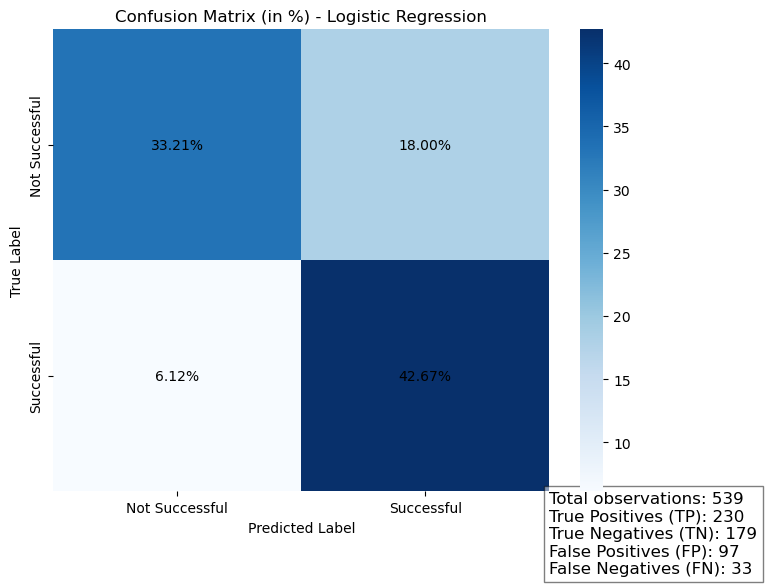

In [7]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
total_observations = np.sum(conf_matrix)
conf_matrix_percent = conf_matrix / total_observations * 100

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="Blues", cbar=True, xticklabels=['Not Successful', 'Successful'], yticklabels=['Not Successful', 'Successful'])

# Manually add the annotations in percentages
for i in range(conf_matrix_percent.shape[0]):
    for j in range(conf_matrix_percent.shape[1]):
        plt.text(j + 0.5, i + 0.5, f'{conf_matrix_percent[i, j]:.2f}%', ha='center', va='center', color='black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (in %) - Logistic Regression')

# Display total observations and individual counts
tp = conf_matrix[1, 1]
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]

plt.text(2, 2, f'Total observations: {total_observations}\n'
               f'True Positives (TP): {tp}\n'
               f'True Negatives (TN): {tn}\n'
               f'False Positives (FP): {fp}\n'
               f'False Negatives (FN): {fn}', 
         fontsize=12, ha='left', va='top', color='black', 
         bbox=dict(facecolor='white', alpha=0.5))

plt.show()

## ROC Curve

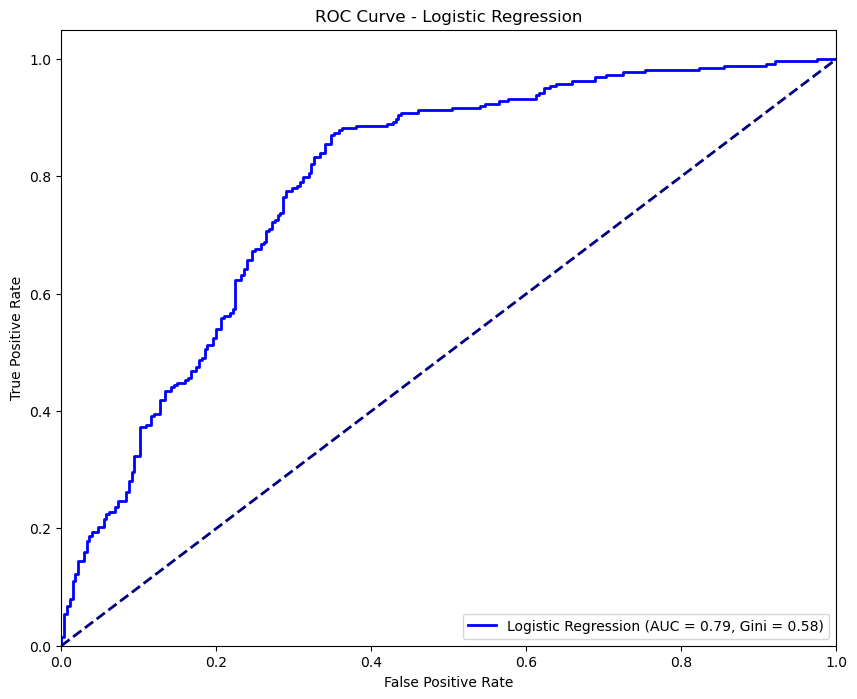

In [8]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc:.2f}, Gini = {gini:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


## Gini Curve

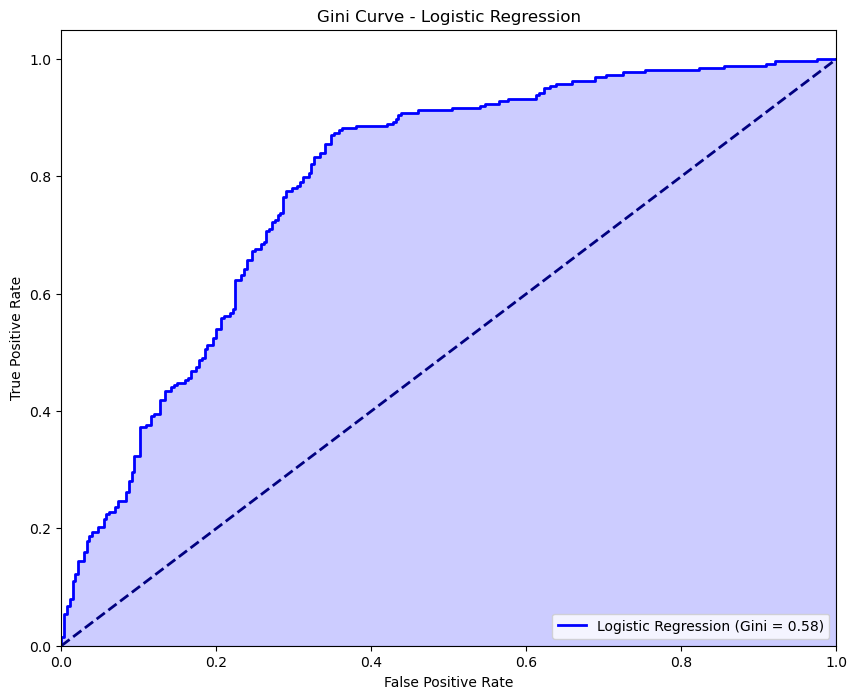

In [9]:
# Gini Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Logistic Regression (Gini = {gini:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.fill_between(fpr, tpr, alpha=0.2, color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gini Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [10]:
import joblib

# Assuming your logistic regression model is trained and stored in the variable `log_reg_model`
joblib.dump(log_reg_model, 'log_reg_model.pkl')


['log_reg_model.pkl']